In [1]:
import keras 
from keras import optimizers
from keras import losses
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Dropout,Embedding,LSTM
from keras.optimizers import RMSprop,Adam,Nadam
from keras.preprocessing import sequence 
from keras.callbacks import TensorBoard
from keras.utils import plot_model

import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import pickle

import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow
import time 

import sys


Using TensorFlow backend.


In [2]:
 # Visualisation class
class Visualization:
    
    labels=["Normal","Anomaly"]
    
    def drow_confusion_matrix(self,y,ypred):
        matrix=confusion_matrix(y,ypred)
        plt.figure(figsize=(15,10))
        colors=["indianred","lightseagreen"]
        sns.heatmap(matrix,xticklabels=self.labels,yticklabels=self.labels,cmap=colors,annot=True,fmt="d")
        plt.title("confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel("Predicted")
        plt.show()
    
    
    def drow_anomaly(self,y,error,threshold):
        groupsDF=pd.DataFrame({
            "error":error,
            "true":y
        }).groupby("true")
        
        figure , axes= plt.subplots(figsize=(12,8))
        for name,group in groupsDF:
            axes.plot(
                      group.index,group.error,marker="x" if name == 1 else "o",linestyle='',
                      color='r' if name==1 else "teal" , label="Anomaly" if name==1 else "Normal"
                     )
            
        axes.hlines(threshold,axes.get_xlim()[0],axes.get_xlim()[1],color="b",zorder=100,label='Thershold')
        axes.legend()
        plt.title("Anomalie")
        plt.xlabel("Data")
        plt.ylabel("Error")
        plt.show()
            
    
    def drow_error(self,error,threshold):
        plt.plot(error,marker="o",ms=3.5,linestyle="",label="Point")
        plt.hlines(threshold,xmin=0,xmax=len(error)-1,colors="b",zorder=100,label="Threshold")
        plt.legend()
        plt.title("Reconstruction Error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
            

In [3]:
df =pd.read_csv("../../data/full_data_small_datased.csv")
df.shape

(278060, 116)

In [4]:
def transformer_df(df):
    dic={}
    for c in df.columns :
        if (df[c].dtype =="object"):
            encoder = LabelEncoder()
            encoder.fit(df[c])
            df[c]=encoder.transform(df[c])
            dic[c]=encoder
    with open("./models/LabelEncoders_dic.pickle","wb") as f:
        pickle.dump(dic,f)
    return df

In [5]:
def shuffle_dataframe(df):
    df = shuffle(df)
    return df

In [6]:
def normaliser_all_columns(df):
    diction={}
    
    for c in df.columns :
        scaler=MinMaxScaler(feature_range=(0,1)).fit(df[c].values.reshape(-1,1))
        diction[c]=scaler        
        df[c]=scaler.transform(df[c].values.reshape(-1,1))
    with open("./models/MinMaxScalers_dic.pickle","wb") as f:
        pickle.dump(diction,f)
    return df

In [7]:
df=transformer_df(df)
df=normaliser_all_columns(df)
df=shuffle_dataframe(df)

In [8]:
xtrain,xtest,ytrain,ytest=train_test_split(df.drop(labels=["Class"],axis=1),df["Class"],test_size=0.2)

In [9]:
def add_noise(xtrain,xtest,ytrain,ytest):
    noise_factor=0.3
    xtrain_noise=xtrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtrain.shape)
    xtest_noise=xtest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=xtest.shape)
    ytrain_noise=ytrain + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytrain.shape)
    ytest_noise=ytest + noise_factor *np.random.normal(loc=0.0,scale=1.0,size=ytest.shape)
    xtrain_noise=np.clip(xtrain_noise,0.,1.)
    xtest_noise=np.clip(xtest_noise,0.,1.)
    ytrain_noise=np.clip(ytrain_noise,0.,1.)
    ytest_noise=np.clip(ytest_noise,0.,1.)
    return xtrain_noise,xtest_noise,ytrain_noise,ytest_noise

In [10]:
xtrain_noise,xtest_noise,ytrain_noise,ytest_noise=add_noise(xtrain,xtest,ytrain,ytest)

## Create and train the ML algorithm using the output of the DAE model

In [11]:
xgb = XGBClassifier()

## Create the DAE model

In [12]:
def create_dae(input_dim):
    
    dae_input=Input(shape=(input_dim,)) #Define the input layer
    
    encoded= Dense(units=input_dim,activation="tanh")(dae_input) 
    encoded= Dense(units=int(input_dim/2),activation="tanh")(encoded) 
    encoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    encoded= Dense(units=10,activation="tanh")(encoded)
    encoded= Dense(units=3,activation="tanh")(encoded)
    encoded= Dense(units=int(input_dim/8),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/4),activation="tanh")(encoded)
    decoded= Dense(units=int(input_dim/2),activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="tanh")(decoded)
    decoded= Dense(units=input_dim,activation="softmax",name='decoded')(decoded) #softmax return a vector of probabilty describing the importance of each attribute 
    autoecoder=Model(dae_input,decoded)# the input layer and the output layer 
    autoecoder.summary()
    autoecoder.compile(optimizer=RMSprop(),loss="mean_squared_error",metrics=["mae"])
    plot_model(autoecoder,to_file='dae.png',show_shapes=True)
    return autoecoder

In [13]:
denosed_autoecoder = create_dae(xtrain.shape[1])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 115)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 115)               13340     
_________________________________________________________________
dense_2 (Dense)              (None, 57)                6612      
_________________________________________________________________
dense_3 (Dense)              (None, 28)                1624      
_________________________________________________________________
dense_4 (Dense)              (None, 14)                406       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                150       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33  

In [14]:
#hyperparametrs :
batchsize=100
epoch=10
start_time = time.time() 
history = denosed_autoecoder.fit(xtrain_noise,xtrain,
              batch_size=batchsize,
              epochs=epoch,
              verbose=1,
              shuffle=True,
              validation_data=(xtest_noise,xtest),
              callbacks=[TensorBoard(log_dir="../logs/Denoiseautoencoder")])


Train on 222448 samples, validate on 55612 samples
Epoch 1/10
222448/222448 [==============================] - 6s 28us/step - loss: 0.2769 - mae: 0.3585 - val_loss: 0.2755 - val_mae: 0.3569
Epoch 2/10
222448/222448 [==============================] - 6s 26us/step - loss: 0.2769 - mae: 0.3584 - val_loss: 0.2755 - val_mae: 0.3569
Epoch 3/10
222448/222448 [==============================] - 6s 26us/step - loss: 0.2768 - mae: 0.3584 - val_loss: 0.2750 - val_mae: 0.3569
Epoch 4/10
222448/222448 [==============================] - 6s 26us/step - loss: 0.2764 - mae: 0.3584 - val_loss: 0.2750 - val_mae: 0.3569
Epoch 5/10
222448/222448 [==============================] - 8s 37us/step - loss: 0.2764 - mae: 0.3584 - val_loss: 0.2750 - val_mae: 0.3569
Epoch 6/10
222448/222448 [==============================] - 6s 27us/step - loss: 0.2764 - mae: 0.3584 - val_loss: 0.2750 - val_mae: 0.3569
Epoch 7/10
222448/222448 [==============================] - 6s 26us/step - loss: 0.2764 - mae: 0.3584 - val_loss: 0

In [15]:
xtrain_ml=denosed_autoecoder.predict(xtrain_noise)

In [16]:
xgb = xgb.fit(pd.DataFrame(xtrain_ml), pd.DataFrame(ytrain))
print("--- %s seconds ---" % (time.time() - start_time))

/home/houssem/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/houssem/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


--- 112.1256456375122 seconds ---


In [17]:
%load_ext tensorboard
%tensorboard --logdir {"../logs/Denoiseautoencoder/"}

## Get the predict output dataset from DAE model to use it as the test dataset of the ML algorithm 

In [19]:
start_time = time.time() 
xtest_ml=pd.DataFrame(denosed_autoecoder.predict(xtest_noise))
y_pred = xgb.predict(xtest_ml)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.0750336647033691 seconds ---


## Evaluer lalgorithme 

In [20]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8070
         1.0       1.00      1.00      1.00     47542

    accuracy                           1.00     55612
   macro avg       1.00      1.00      1.00     55612
weighted avg       1.00      1.00      1.00     55612



In [21]:
print('precision_score : '+str(precision_score(ytest, y_pred, average='weighted')))
print('accuracy_score : '+str(accuracy_score(ytest, y_pred)))
print('recall_score : '+str(recall_score(ytest, y_pred, average='weighted')))
print('f1_score : '+str(f1_score(ytest, y_pred, average='weighted')))
print('roc_auc_score : '+str(roc_auc_score(ytest,y_pred))) # TruePositive,TrueNegative
tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
print('True_positive : '+str(tp)+', False_positive : '+str(fp)+', True_negative : '+str(tn)+', False_negative : '+str(fn))

precision_score : 0.9999640365388766
accuracy_score : 0.9999640365388766
recall_score : 0.9999640365388766
f1_score : 0.9999640365388766
roc_auc_score : 0.999927525114818
True_positive : 47541, False_positive : 1, True_negative : 8069, False_negative : 1


In [22]:
viz=Visualization()

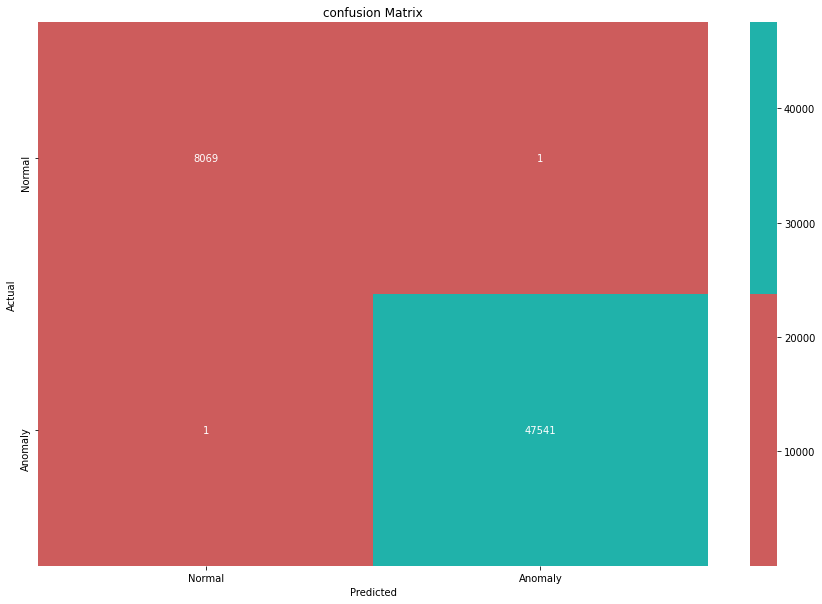

In [23]:
viz.drow_confusion_matrix(ytest,y_pred)

### Save models

In [24]:
# save the models to disk
denosed_autoecoder.save("./models/dae.h5")
pickle.dump(xgb, open('./models/xgb.pkl', 'wb'))